# Gretel Trainer

This notebook is designed to help users successfully train synthetic models on complex datasets with high row and column counts. The code works by intelligently dividing a dataset into a set of smaller datasets of correlated columns that can be parallelized and then joined together. 

In [1]:
import strategy
import runner

from gretel_client.projects import create_or_get_unique_project
from gretel_client.projects.models import read_model_config
from gretel_client.projects.jobs import Status
from gretel_synthetics.utils.header_clusters import cluster

import pandas as pd

In [2]:
# Parallelization parameters and options

MAX_ROWS = 20000 # Maximum row count per model
MAX_HEADER_CLUSTERS = 10 # Max columns per cluster
CACHE_FILE = "runner.json"
PROJECT = create_or_get_unique_project(name="mitre-health")

print(f"Follow model training at: {PROJECT.get_console_url()}")

Follow model training at: https://console.gretel.cloud/mitre-health-ff62139634


In [3]:
# Load the dataset to synthesize

DATASET_PATH = 'mitre-synthea-health.csv'
ROUND_DECIMALS = 4


def preprocess_data(dataset_path: str) -> pd.DataFrame:
    tmp = pd.read_csv(dataset_path, low_memory=False, nrows=100000)
    tmp = tmp.round(ROUND_DECIMALS)
    return tmp
    
DF = preprocess_data(DATASET_PATH)
DF

,EventDate,DATE,PatientID,BirthDate,DeathDate,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,...,EncounterReason,EncounterReasonDesc,ObsCode,ObsDesc,ObsValue,ObsValueFloat,UNITS,ProcedureDate,ProcedureDesc,ProcedureReason
0,2013-06-07,2013-07-01,d091c3eb,1937-03-02,1900-01-01,white,french,M,MA US,01202 US,...,NaN,NaN,6298-4,Potassium,6.5074,6.5074,mmol/L,2016-03-03,Documentation of current medications,NaN
1,2011-01-28,2010-12-16,0bdda8d2,1984-06-11,1900-01-01,black,african,F,MA US,01910 US,...,NaN,NaN,6298-4,Potassium,6.5325,6.5325,mmol/L,2014-03-02,Intramuscular injection,NaN
2,2016-09-06,2016-10-03,f0577b5f,1977-08-24,1900-01-01,white,english,M,MA US,02140 US,...,NaN,NaN,6298-4,Potassium,6.5200,6.5200,mmol/L,2012-08-31,Biopsy of colon,68496003.0
3,2012-05-05,2012-04-26,a9fb85a6,1954-03-14,1900-01-01,white,french,M,MA US,01202 US,...,NaN,NaN,6298-4,Potassium,6.5074,6.5074,mmol/L,2012-04-28,Documentation of current medications,NaN
4,2011-01-28,2010-12-16,0bdda8d2,1984-06-11,1900-01-01,white,german,M,MA US,01853 US,...,10509002.0,Acute bronchitis (disorder),6298-4,Potassium,6.5200,6.5200,mmol/L,2011-02-04,Documentation of current medications,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2013-06-20,2013-07-16,a4a433e9,1941-11-06,1900-01-01,hispanic,mexican,M,MA US,01813 US,...,NaN,NaN,6298-4,Potassium,6.5074,6.5074,mmol/L,2014-06-04,Colonoscopy,NaN
2281,2013-07-09,2013-06-03,17f227c5,1940-07-04,1900-01-01,hispanic,mexican,F,MA US,02211 US,...,444814009.0,Viral sinusitis (disorder),6298-4,Potassium,6.5074,6.5074,mmol/L,2013-02-13,Documentation of current medications,NaN
2282,2017-08-12,2017-05-19,7ce419ba,1944-08-07,1900-01-01,white,french,M,MA US,01202 US,...,NaN,NaN,6298-4,Potassium,6.5074,6.5074,mmol/L,2013-05-02,Documentation of current medications,NaN
2283,2016-12-03,2016-12-07,a9c0db54,1974-12-09,1900-01-01,white,swedish,F,MA US,01844 US,...,NaN,NaN,6298-4,Potassium,6.5325,6.5325,mmol/L,2015-05-23,Documentation of current medications,NaN


In [4]:
# Load a default configuration from GitHub

CONFIG = read_model_config("synthetics/default")
CONFIG["models"][0]["synthetics"]["params"]["vocab_size"] = 0
CONFIG["models"][0]["synthetics"]["params"]["learning_rate"] = 0.001
CONFIG["models"][0]["synthetics"]["privacy_filters"] = {}
CONFIG["models"][0]["synthetics"]["privacy_filters"]["outliers"] = None
CONFIG["models"][0]["synthetics"]["privacy_filters"]["similarity"] = None

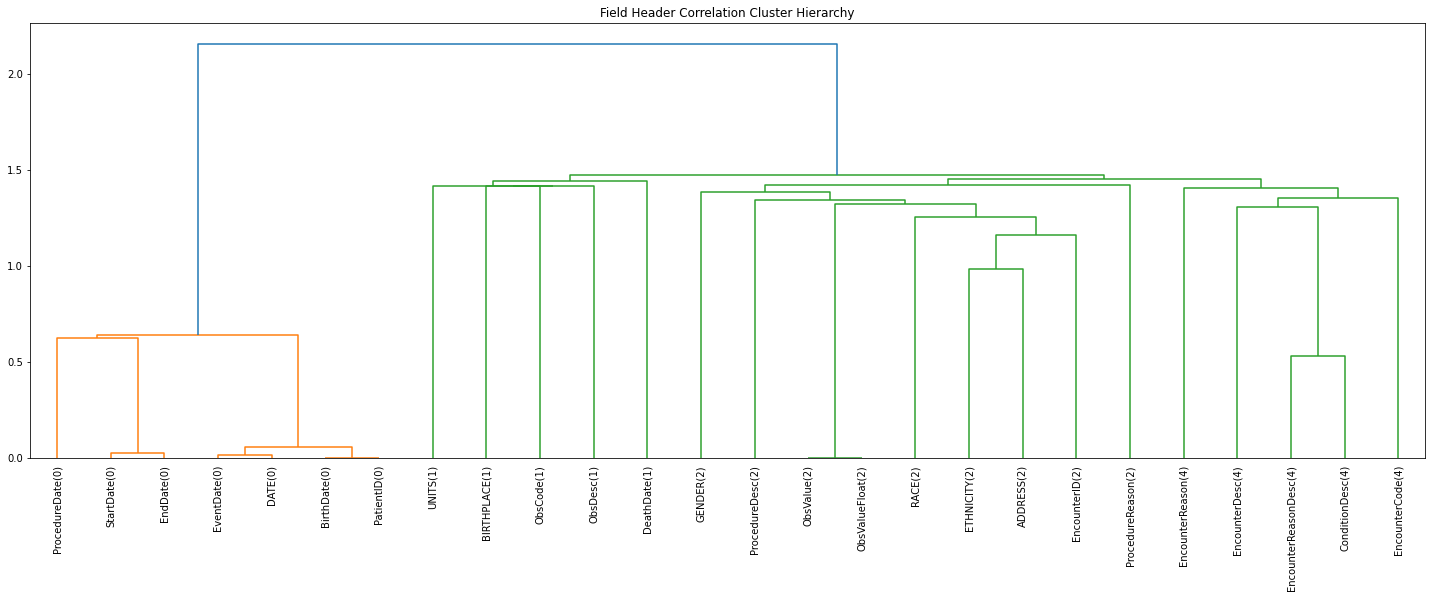

In [5]:
# Initialize the parallelization strategy

def initialize_run() -> runner.StrategyRunner:
    
    # Create clusters of correlated columns (might take a few minutes)
    header_clusters = cluster(DF, maxsize=MAX_HEADER_CLUSTERS, plot=True) 

    constraints = strategy.PartitionConstraints(
        header_clusters=header_clusters, 
        max_row_count=MAX_ROWS
    )
    
    run = runner.StrategyRunner(
        strategy_id="foo",
        df=DF,
        cache_file=CACHE_FILE,
        cache_overwrite=True,  # False means we'll try and load an existing cache and start back up, otherwise start fresh
        model_config=CONFIG,
        partition_constraints=constraints,
        project=PROJECT
    )    
    return run

run = initialize_run()

In [6]:
run.train_all_partitions()

INFO:runner:Processing 4 partitions
INFO:runner:Partition 0 is new, starting model creation
INFO:runner:Started model: dazzling-unkempt-bear source: ['gretel_71d05cfcabe04695aa1aaffb933732cb_foo-0.csv']
INFO:runner:Partition 1 is new, starting model creation
INFO:runner:Started model: jazzy-goofy-ferret source: ['gretel_1241af3dfb914f0491606bc56d115118_foo-1.csv']
INFO:runner:Partition 0 status change from created to pending
INFO:runner:Partition 1 status change from created to pending
INFO:runner:Partition 2 is new, starting model creation
INFO:runner:Started model: nimble-excited-peacock source: ['gretel_eb96ce37d0a64267925be97606903929_foo-2.csv']
INFO:runner:Partition 3 is new, starting model creation
INFO:runner:Started model: puzzled-brave-raccoon source: ['gretel_d7b921a6fa764d13b998bf504ea0d0b1_foo-3.csv']
INFO:runner:Partition 2 status change from created to pending
INFO:runner:Partition 3 status change from created to pending
INFO:runner:Partition 1 status change from pending

In [7]:
synthetic = run.get_training_synthetic_data()
synthetic = synthetic[DF.columns]
synthetic.to_csv('synthetic.csv', index=False)
synthetic

,ProcedureDate,StartDate,EndDate,EventDate,DATE,BirthDate,PatientID,UNITS,BIRTHPLACE,ObsCode,...,RACE,ETHNICITY,ADDRESS,EncounterID,ProcedureReason,EncounterReason,EncounterDesc,EncounterReasonDesc,ConditionDesc,EncounterCode
0,2014-01-03,2017-02-12,2017-03-05,2015-12-25,2016-02-10,1945-08-07,2e1cb472,mmol/L,MA US,6298-4,...,white,french,02481 US,20450b8b,NaN,NaN,Outpatient Encounter,NaN,Asthma,185349003
1,2011-01-08,2011-02-03,2010-12-25,2011-01-28,2010-12-16,1984-06-11,0bdda8d2,mmol/L,MA US,6298-4,...,white,italian,02478 US,ef43988c,NaN,NaN,Hutpatient Encounter,NaN,Asthma,185349003
2,2016-05-24,2017-04-08,2017-05-11,2015-12-17,2016-01-28,1956-04-20,0f2c2995,mmol/L,MA US,6298-4,...,black,african,02124 US,9f3fc317,NaN,NaN,Outpatient Encounter,NaN,Diabetes,185349003
3,2013-07-28,2013-08-08,2013-10-19,2014-01-15,2014-01-03,1937-08-18,7589c26f,mmol/L,MA US,6298-4,...,white,irish,02124 US,0b487aea,NaN,NaN,Encounter for 'check-up',NaN,Stroke,185349003
4,2016-06-06,2014-12-14,2014-12-28,2013-07-09,2013-06-03,1940-07-04,17f227c5,mmol/L,MA US,6298-4,...,white,italian,01910 US,603cb149,NaN,NaN,Outpatient Encounter,NaN,Prediabetes,185349003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2013-04-23,2013-02-27,2013-05-29,2014-04-21,2014-01-30,1928-03-06,3a751299,mmol/L,MA US,6298-4,...,white,italian,02238 US,b51749a2,NaN,NaN,Outpatient Encounter,NaN,Prediabetes,185349003
2281,2014-04-11,2010-10-08,2010-09-10,2013-06-20,2013-07-16,1941-11-06,a4a433e9,mmol/L,MA US,6298-4,...,hispanic,puerto_rican,02048 US,dd0248e8,NaN,NaN,Outpatient Encounter,NaN,Prediabetes,185349003
2282,2014-02-02,1985-04-05,1985-02-15,2016-07-04,2016-07-09,1971-07-30,1e2a4b7f,mmol/L,MA US,6298-4,...,hispanic,puerto_rican,01746 US,05748d0f,NaN,NaN,Outpatient Encounter,NaN,Prediabetes,185349003
2283,2015-10-11,2012-01-03,2012-01-10,2014-02-20,2013-11-20,1955-11-12,46f6851c,mmol/L,MA US,6298-4,...,white,swedish,01844 US,ef654a5a,284549007.0,NaN,Outpatient Encounter,NaN,Prediabetes,185349003


In [9]:
#run.cancel_all()
#PROJECT.delete()

In [22]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from gretel_synthetics.utils.header_clusters import _get_correlation_matrix

synthetic_corr = _get_correlation_matrix(synthetic)
realworld_corr = _get_correlation_matrix(DF)

fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.2)
fig.update_layout(title_text="Real world vs. Synthetic Correlations")
trace1 = go.Heatmap(z=realworld_corr, y=realworld_corr.index, x=realworld_corr.columns)
trace2 = go.Heatmap(z=synthetic_corr, y=synthetic_corr.index, x=synthetic_corr.columns)


fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.update_traces(showscale=False)
fig.show()